In [1]:
import re
import math
import importlib
import spacy
import torch
import torch.nn as nn
from torch.autograd import Variable
import fire

# 构建分词器

In [2]:
class Tokenize(object):
    def __init__(self, lang):
        self.nlp = importlib.import_module(lang).load()
        
    def tokenizer(self,sentence):
        sentence = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+"," ",sentence) #多个空格替换成一个空格
        sentence = re.sub(r"\!+","!", sentence) #多个变一个
        sentence = re.sub(r"\,+",",",sentence)
        sentence = re.sub(r"\?+","?",sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text !=" "]


In [3]:
tokenize = Tokenize('zh_core_web_sm')
tokenize.tokenizer('你好，这里是中国。')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.671 seconds.
Prefix dict has been built successfully.


['你好', '，', '这里', '是', '中国', '。']

# Input Embedding
给语句分词后，就得到了一个个的 token，要对这些token做向量化的表示，这里使用 pytorch 中torch.nn.Embedding 让模型学习到这些向量。

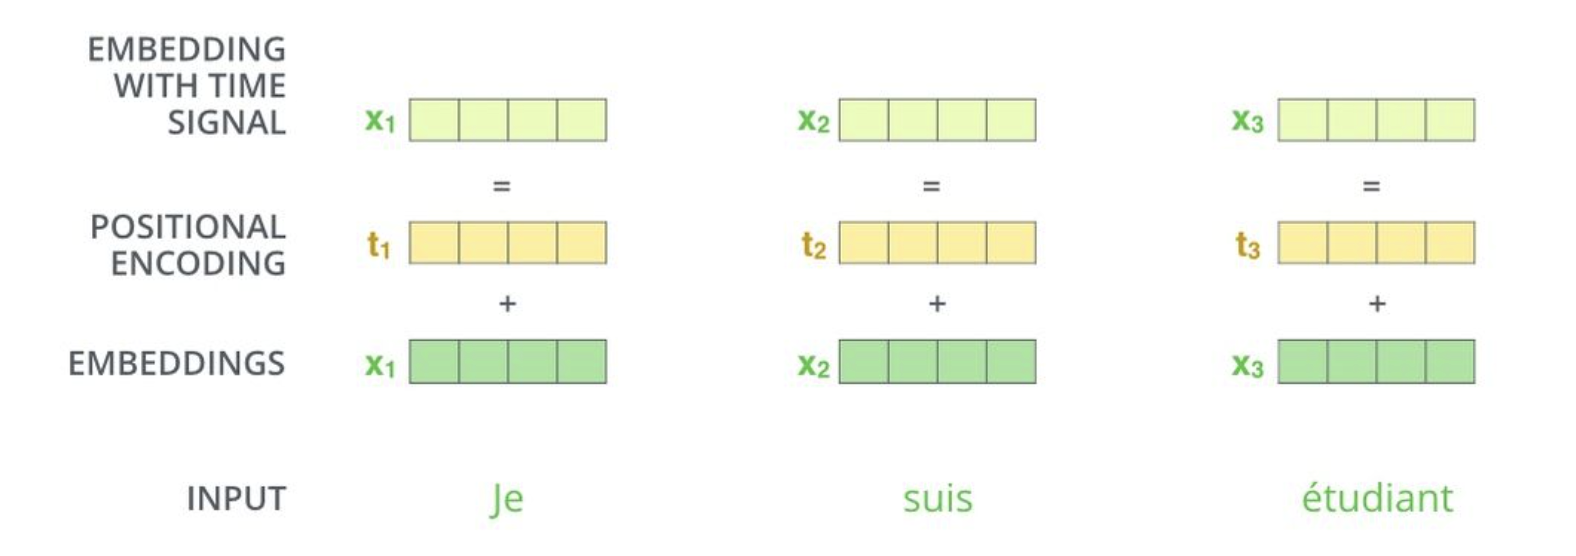

In [6]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x)

# Positional Encoder
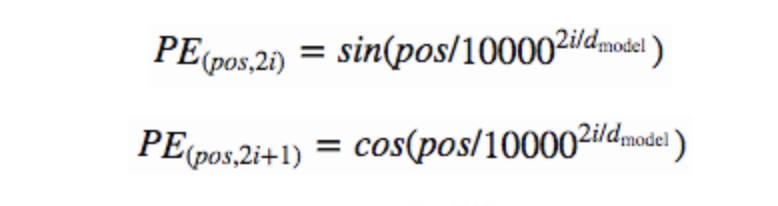

In [16]:
class PositionEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        
        # 根据pos和i创建一个常量pe矩阵
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] =  math.sin(pos/(10000**((2*i)/d_model)))
                pe[pos, i+1] = math.cos(10000**((2*(i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # 让embedding vector相对大一些
        x = x* math.sqrt(self.d_model)
        #增加位置常量到embedding中
        seq_len = x.size()
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x

# Transformer Block
self-attention layer /normalization layer /feed forward layer /another normalization layer 
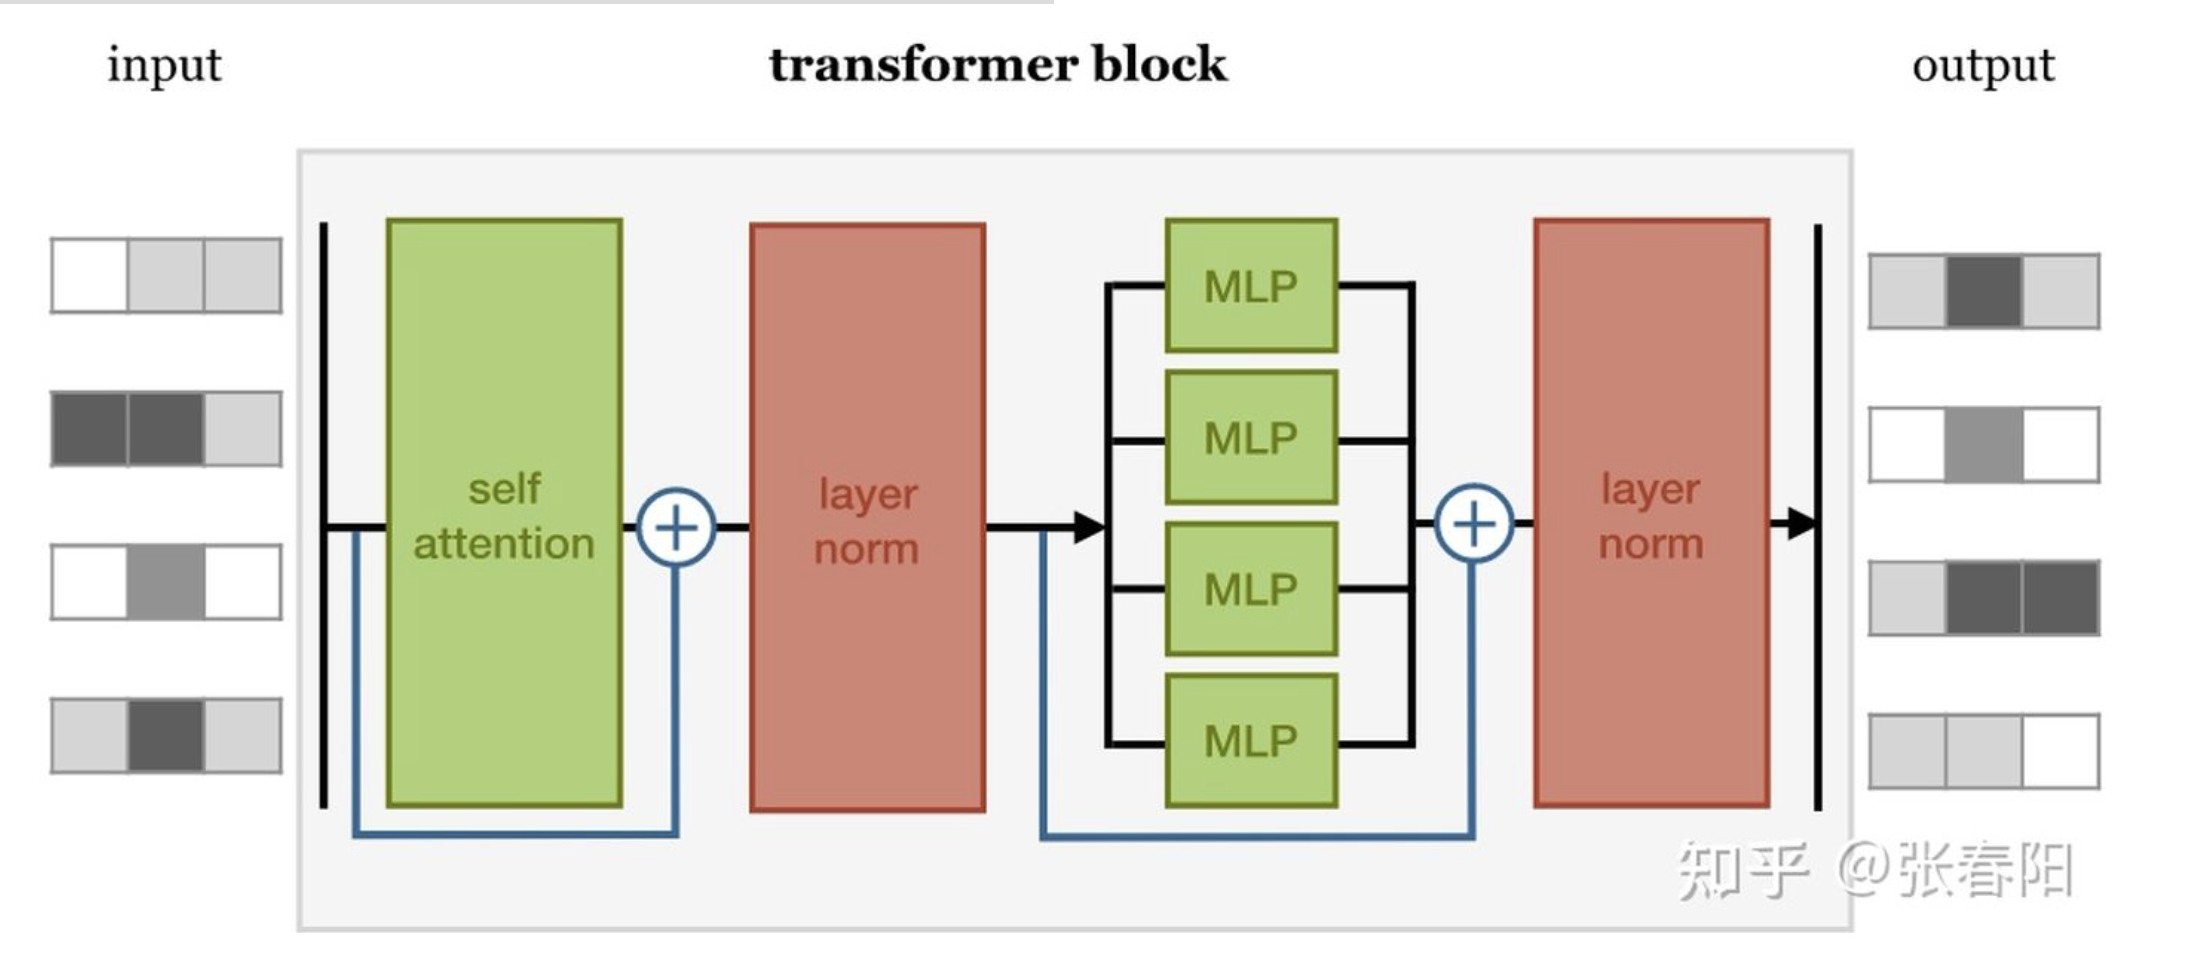

In [17]:
def attention(q, k, v, d_k , mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
    # mask哪些为了padding长度增加的token，让其通过softmax计算后为0
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.mask_fill(mask==0, 1e-9)
        
    scores = F.softmax(scores, dim=-1)
    if dropout is not None:
        scores=dropout(scores)
    output = torch.matmul(scores, v)
    return output

- 这个 attention 的代码中，使用 mask 的机制，这里主要的意思是因为在去给文本做 batch 化的过程中，需要序列都是等长的，不足的部分需要 padding。
- 但是这些 padding 的部分，我们并不想在计算的过程中起作用，所以使用 mask 机制，将这些值设置成一个非常大的负值，这样才能让 softmax 后的结果为 0。
- 关于 mask 机制，在 Transformer 中有 attention、encoder 和 decoder 中，有不同的应用

# MultiHeadAttention

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model//heads
        self.h =heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        
        # 执行线性运算并拆分成N个磁头
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # https://zhuanlan.zhihu.com/p/64551412
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        return output

In [20]:
# Norm Layer
class NormLayer(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self,x):
        norm = self.alpha*(x - x.mean(dim=-1, keepdim=True))/ (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [21]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        # we set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)

In [22]:
def get_clones(module , N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [23]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

In [24]:
class Decoder(nn.Module):
    
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [25]:
class Transformer(nn.Module):
    
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
        
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output